In [1]:
from google.colab import drive
drive.mount('/content/drive')

abspath_curr = '/content/drive/My Drive/Colab Notebooks/MLII/'
abspath_data_quac = '/content/drive/My Drive/Colab Notebooks/MLII/data_quac/'
abspath_data_qnli = '/content/drive/My Drive/Colab Notebooks/MLII/data_qnli/QNLIv2/'
abspath_data_qna = '/content/drive/My Drive/Colab Notebooks/MLII/data_qna/'

abspath_model = '/content/drive/My Drive/Colab Notebooks/MLII/models/'
abspath_plots = '/content/drive/My Drive/Colab Notebooks/MLII/plots/'

Mounted at /content/drive


In [2]:
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.4MB 6.2MB/s 
     |████████████████████████████████| 1.1MB 6.3MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 174kB 12.2MB/s 
     |████████████████████████████████| 1.2MB 5.7MB/s 
     |████████████████████████████████| 706kB 22.1MB/s 
     |████████████████████████████████| 37.6MB 144kB/s 
     |████████████████████████████████| 358kB 70.8MB/s 
     |████████████████████████████████| 645kB 69.8MB/s 
     |████████████████████████████████| 3.8MB 6.0MB/s 


In [3]:
# tf imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

# other libs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from os import listdir
import pickle
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
def probs(x):
    if x < 0.5:
        return 0
    else:
        return 1

def print_scores(label, pred):
    print(f'Accuracy_score: {accuracy_score(label, pred):.2f}', 
    f'f1_score: {f1_score(label, pred):.2f}', 
    f'recall_score: {recall_score(label, pred):.2f}', 
    f'precision_score: {precision_score(label, pred):.2f}', sep='\n', end='\n\n')
    return {'Accuracy_score': accuracy_score(label, pred), 'f1_score': f1_score(label, pred), 
            'recall_score': recall_score(label, pred), 'precision_score': precision_score(label, pred)}

random_state=81

In [7]:
df_qna_60k = pd.read_csv(abspath_data_qna+'df_qna_60k.csv')

In [10]:
remainder, test_df = train_test_split(df_qna_60k, test_size=0.25, shuffle=True,random_state=random_state, stratify=df_qna_60k.label.values)
train_df, val_df = train_test_split(remainder, test_size=0.1, shuffle=True,random_state=random_state, stratify=remainder.label.values)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
print(test_df.shape, train_df.shape, val_df.shape)
print(test_df.isna().sum().sum(), train_df.isna().sum().sum(), val_df.isna().sum().sum())

(15000, 5) (40500, 5) (4500, 5)
0 0 0


In [12]:
train_df.head()

,Unnamed: 0,query_id,query,sentence,label
0,2051657,728529,what is causing pain in my hands,Carpal tunnel syndrome. Carpal tunnel syndrome...,0
1,7577965,116307,declarations definition,the act of declaring; announcement: a declarat...,0
2,7857251,749831,what is galvanisation,"Galvanization, or galvanisation, is the proces...",1
3,7803460,650818,what does the medical term faan mean,"All content on this website, including diction...",0
4,6130127,1039925,who is the deputy taoiseach,The Tanaiste (/tánaiste/) ˈtɔːnɨʃtə is the dep...,1


# Loading models from TensorFlow Hub

In [13]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
                      'bert_en_uncased_L-24_H-1024_A-16': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3'}
  

map_model_to_preprocess = {'bert_en_uncased_L-24_H-1024_A-16': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                           'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [14]:
bert_preprocess_768 = hub.load(tfhub_handle_preprocess)

# Data pre-processing

In [15]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset_from_tfds(dataset, batch_size, bert_preprocess_model):
  num_examples = int(len(list(dataset)))
  dataset_b = dataset.batch(batch_size)
  dataset_b = dataset_b.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset_b = dataset_b.cache().prefetch(AUTOTUNE)
  return dataset_b, num_examples

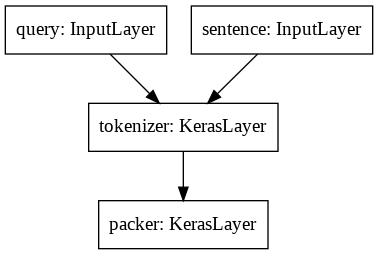

In [19]:
sentence_features = ['query', 'sentence']
num_classes = 2

bert_preprocess_model_128 = make_bert_preprocess_model(sentence_features, 128)
bert_preprocess_model_256 = make_bert_preprocess_model(sentence_features, 256)
bert_preprocess_model_512 = make_bert_preprocess_model(sentence_features, 512)
tf.keras.utils.plot_model(bert_preprocess_model_128)

In [20]:
# QNA only unbatched
train_dataset_unb = tf.data.Dataset.from_tensor_slices({'idx':train_df.index.values, 'query':train_df['query'].values, 'sentence':train_df.sentence.values, 
                                                    'label':train_df.label.values})
val_dataset_unb = tf.data.Dataset.from_tensor_slices({'idx':val_df.index.values, 'query':val_df['query'].values, 'sentence':val_df.sentence.values, 
                                                  'label':val_df.label.values})
test_dataset_unb = tf.data.Dataset.from_tensor_slices({'idx':test_df.index.values, 'query':test_df['query'].values, 'sentence':test_df.sentence.values, 
                                                   'label':test_df.label.values})

# Define Model

In [21]:
def build_classifier_model(num_classes=2, activation=None):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids'),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask'),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids'),
  )

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=0.1)(net)
  net = tf.keras.layers.Dense(num_classes, activation=activation, name='classifier')(net)
  return tf.keras.Model(inputs, net, name='prediction')

In [22]:
classifier_model_example = build_classifier_model(2)
print(classifier_model_example.summary())

Model: "prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder (KerasLayer)            {'encoder_outputs':  109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]    

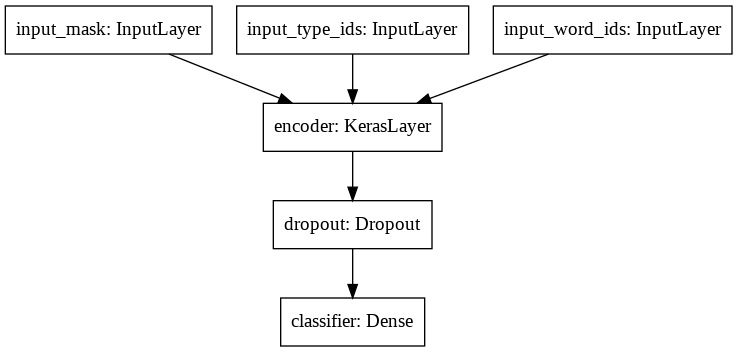

In [23]:
tf.keras.utils.plot_model(classifier_model_example)

## Train Model

### Training with sequence length 128

In [24]:
batch_size = 16
epochs = 1
init_lr = 1e-5
# the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

print(f'Fine tuning {tfhub_handle_encoder} model')

train_dataset_, train_data_size= load_dataset_from_tfds(train_dataset_unb, batch_size, bert_preprocess_model_128)
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

val_dataset_, val_data_size= load_dataset_from_tfds(val_dataset_unb, batch_size, bert_preprocess_model_128)
validation_steps = val_data_size // batch_size

print('steps_per_epoch : ', steps_per_epoch)
print('num_train_steps : ', num_train_steps)
print('num_warmup_steps: ', num_warmup_steps)
print('validation_steps: ', validation_steps)
print('train_data_size : ', train_data_size)
print('val_data_size   : ', val_data_size)
print('batch_size      : ', batch_size)
print('epochs          : ', epochs)

classifier_model = build_classifier_model(num_classes)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
optimizer = optimization.create_optimizer(init_lr = init_lr, num_train_steps = num_train_steps, 
                                          num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

history_1 = classifier_model.fit(x = train_dataset_, validation_data = val_dataset_, steps_per_epoch=steps_per_epoch, 
                                epochs=epochs, validation_steps=validation_steps)
history_2 = classifier_model.fit(x = train_dataset_, validation_data = val_dataset_, steps_per_epoch=steps_per_epoch, 
                                epochs=epochs, validation_steps=validation_steps)
history_3 = classifier_model.fit(x = train_dataset_, validation_data = val_dataset_, steps_per_epoch=steps_per_epoch, 
                                epochs=epochs, validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model
steps_per_epoch :  2531
num_train_steps :  2531
num_warmup_steps:  253
validation_steps:  281
train_data_size :  40500
val_data_size   :  4500
batch_size      :  16
epochs          :  1
2531/2531 [==============================] - 679s 268ms/step - loss: 0.5012 - accuracy: 0.7526 - val_loss: 0.5358 - val_accuracy: 0.7224


In [38]:
list(train_dataset_unb.as_numpy_iterator())[0]
tok1 = bert_preprocess_768.tokenize(tf.constant(['what is causing pain in my hands']))
tok2 = bert_preprocess_768.tokenize(tf.constant(['Carpal tunnel syndrome. Carpal tunnel syndrome is a painful condition caused by a pinched nerve in the wrist that leads to radiating pain, weakness, or numbness in the palm side of the hand, wrist or fingers. Treatment includes anti-inflammatory medicine, splinting the wrist, or corticosteroid injections.']))
print(tok1)
print(tok2)

<tf.RaggedTensor [[[2054], [2003], [4786], [3255], [1999], [2026], [2398]]]>
<tf.RaggedTensor [[[29267, 2389], [5234], [8715], [1012], [29267, 2389], [5234], [8715], [2003], [1037], [9145], [4650], [3303], [2011], [1037], [18521], [9113], [1999], [1996], [7223], [2008], [5260], [2000], [23229], [3255], [1010], [11251], [1010], [2030], [15903, 2791], [1999], [1996], [5340], [2217], [1997], [1996], [2192], [1010], [7223], [2030], [3093], [1012], [3949], [2950], [3424], [1011], [20187], [4200], [1010], [11867, 4115, 3436], [1996], [7223], [1010], [2030], [2522, 28228, 13186, 3334, 9314], [13341, 2015], [1012]]]>


In [31]:
# 101 and 102 are tokens to seperate questions from answers as well as padding.
z=list(train_dataset_.as_numpy_iterator())
z[0][0]['input_word_ids'][0]

array([  101,  2054,  2003,  4786,  3255,  1999,  2026,  2398,   102,
       29267,  2389,  5234,  8715,  1012, 29267,  2389,  5234,  8715,
        2003,  1037,  9145,  4650,  3303,  2011,  1037, 18521,  9113,
        1999,  1996,  7223,  2008,  5260,  2000, 23229,  3255,  1010,
       11251,  1010,  2030, 15903,  2791,  1999,  1996,  5340,  2217,
        1997,  1996,  2192,  1010,  7223,  2030,  3093,  1012,  3949,
        2950,  3424,  1011, 20187,  4200,  1010, 11867,  4115,  3436,
        1996,  7223,  1010,  2030,  2522, 28228, 13186,  3334,  9314,
       13341,  2015,  1012,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

### Training with sequence length 256

In [39]:
batch_size_1 = 8
epochs_1 = 1
# the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).
init_lr_1 = 1e-5

print(f'Fine tuning {tfhub_handle_encoder} model')

train_dataset_1, train_data_size_1= load_dataset_from_tfds(train_dataset_unb, batch_size_1, bert_preprocess_model_256)
steps_per_epoch_1 = train_data_size_1 // batch_size_1
num_train_steps_1 = steps_per_epoch_1 * epochs
num_warmup_steps_1 = num_train_steps_1 // 10

val_dataset_1, val_data_size_1= load_dataset_from_tfds(val_dataset_unb, batch_size_1, bert_preprocess_model_256)
validation_steps_1 = val_data_size_1 // batch_size_1

print('steps_per_epoch : ', steps_per_epoch_1)
print('num_train_steps : ', num_train_steps_1)
print('num_warmup_steps: ', num_warmup_steps_1)
print('validation_steps: ', validation_steps_1)
print('train_data_size : ', train_data_size_1)
print('val_data_size   : ', val_data_size_1)
print('batch_size      : ', batch_size_1)
print('epochs          : ', epochs)

optimizer_1 = optimization.create_optimizer(init_lr = init_lr_1, num_train_steps = num_train_steps_1, 
                                          num_warmup_steps=num_warmup_steps_1, optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer_1, loss=loss, metrics=[metrics])

history_4 = classifier_model.fit(x = train_dataset_1, validation_data = val_dataset_1, steps_per_epoch=steps_per_epoch_1, 
                    epochs=epochs, validation_steps=validation_steps_1)
history_5 = classifier_model.fit(x = train_dataset_1, validation_data = val_dataset_1, steps_per_epoch=steps_per_epoch_1, 
                    epochs=epochs_1, validation_steps=validation_steps_1)
history_6 = classifier_model.fit(x = train_dataset_1, validation_data = val_dataset_1, steps_per_epoch=steps_per_epoch_1, 
                    epochs=epochs_1, validation_steps=validation_steps_1)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model
steps_per_epoch :  5062
num_train_steps :  5062
num_warmup_steps:  506
validation_steps:  562
train_data_size :  40500
val_data_size   :  4500
batch_size      :  8
epochs          :  1
5062/5062 [==============================] - 1441s 285ms/step - loss: 0.4219 - accuracy: 0.8102 - val_loss: 0.5151 - val_accuracy: 0.7435


### Training with sequence length 512

In [47]:
batch_size_2 = 8
epochs = 1
# the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).
init_lr_2 = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')

train_dataset_2, train_data_size_2= load_dataset_from_tfds(train_dataset_unb, batch_size_2, bert_preprocess_model_512)
steps_per_epoch_2 = train_data_size_2 // batch_size_2
num_train_steps_2 = steps_per_epoch_2 * epochs
num_warmup_steps_2 = num_train_steps_2 // 10

val_dataset_2, val_data_size_2= load_dataset_from_tfds(val_dataset_unb, batch_size_2, bert_preprocess_model_512)
validation_steps_2 = val_data_size_2 // batch_size_2

print('steps_per_epoch : ', steps_per_epoch_2)
print('num_train_steps : ', num_train_steps_2)
print('num_warmup_steps: ', num_warmup_steps_2)
print('validation_steps: ', validation_steps_2)
print('train_data_size : ', train_data_size_2)
print('val_data_size   : ', val_data_size_2)
print('batch_size      : ', batch_size_2)
print('epochs          : ', epochs)

# classifier_model = build_classifier_model(num_classes)


optimizer_2 = optimization.create_optimizer(init_lr = init_lr_2, num_train_steps = num_train_steps_2, 
                                          num_warmup_steps=num_warmup_steps_2, optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer_2, loss=loss, metrics=[metrics])

history_3 = classifier_model.fit(x = train_dataset_2, validation_data = val_dataset_2, steps_per_epoch=steps_per_epoch_2, 
                    epochs=epochs, validation_steps=validation_steps_2)
history_4 = classifier_model.fit(x = train_dataset_2, validation_data = val_dataset_2, steps_per_epoch=steps_per_epoch_2, 
                    epochs=epochs, validation_steps=validation_steps_2)

2531/2531 [==============================] - 1340s 530ms/step - loss: 0.3084 - accuracy: 0.8814 - val_loss: 0.5277 - val_accuracy: 0.7438


## Test model and save

In [41]:
test_dataset_, test_dataset_size= load_dataset_from_tfds(test_dataset_unb, batch_size_1, bert_preprocess_model_256)

In [42]:
classifier_model.evaluate(test_dataset_)

1875/1875 [==============================] - 158s 84ms/step - loss: 0.5022 - accuracy: 0.7471


[0.5022003650665283, 0.7470666766166687]

In [43]:
tf.keras.models.save_model(classifier_model, abspath_model+'bert_qnli_v0.h5', overwrite=True, include_optimizer=False, save_format=None, 
                           signatures=None, options=None, save_traces=True)
classifier_model = build_classifier_model(2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = optimization.create_optimizer(init_lr = 1e-5, num_train_steps = 5062, num_warmup_steps=506, optimizer_type='adamw')
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
classifier_model.load_weights(abspath_model+'bert_qnli_v0.h5')

In [44]:
classifier_model.evaluate(test_dataset_)

1875/1875 [==============================] - 157s 83ms/step - loss: 0.4999 - accuracy: 0.7535


[0.5022003650665283, 0.7470666766166687]

In [45]:
y_predict = classifier_model.predict(test_dataset_)
y_predict_classes = np.argmax(y_predict, axis=1)
print_scores(test_df['label'],y_predict_classes)

Accuracy_score: 0.75
f1_score: 0.70
recall_score: 0.74
precision_score: 0.66



{'Accuracy_score': 0.7470666666666667,
 'f1_score': 0.6996041171813142,
 'precision_score': 0.6631642149504653,
 'recall_score': 0.7402815013404825}

In [48]:
import os
saved_model_name = 'bert_qnli_v0'
saved_model_path = os.path.join(abspath_model, saved_model_name)

preprocess_inputs = bert_preprocess_model_256.inputs
bert_encoder_inputs = bert_preprocess_model_256(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

model_for_export.save(saved_model_path, include_optimizer=True)

In [49]:
saved_model_name = 'bert_qnli_v0'
saved_model_path = os.path.join(abspath_model, saved_model_name)
reloaded_model = tf.saved_model.load(saved_model_path)

In [52]:
def predict_class(test_dataset_unb, reloaded_model):

  def prepare_gw(record):
    model_inputs = [[record[ft]] for ft in ['query', 'sentence']]
    return model_inputs

  model_inputs = test_dataset_unb.map(prepare_gw)
  num_rows = len(list(test_dataset_unb))
  y_pred = np.zeros(shape=(num_rows, 2))
  # ds_unraveled = [q_s for q_s in tfds.as_numpy(test_dataset_unb)]
  # model_inputs = [[elem['question'], elem['sentence']] for elem in ds_unraveled]
  label =  [elem['label'] for elem in tfds.as_numpy(test_dataset_unb)]

  counter = 0
  for test_row in tqdm(model_inputs): #tqdm()
    result = reloaded_model(list(test_row))
    y_pred[counter] = result
    counter+=1

  bert_result_class = [tf.argmax(bert_result) for bert_result in y_pred]

  return y_pred, bert_result_class, label
#   tfds.as_numpy(reloaded_model(list(test_row))).ravel()

In [53]:
y_pred, bert_result_class, label = predict_class(test_dataset_unb, reloaded_model)

100%|██████████| 15000/15000 [04:25<00:00, 56.43it/s]


In [54]:
print_scores(label,bert_result_class)

Accuracy_score: 0.75
f1_score: 0.70
recall_score: 0.74
precision_score: 0.66



{'Accuracy_score': 0.7470666666666667,
 'f1_score': 0.6996041171813142,
 'precision_score': 0.6631642149504653,
 'recall_score': 0.7402815013404825}

# Result Exploration Analysis

## Scatter Plot with Decision Boundary

In [55]:
# def tp_fp_tn_fn_plot():
tp = []
fp = []
tn = []
fn = []
for i in range(len(y_pred)):
  if (label[i] == bert_result_class[i]) and label[i] == 0:
    tn.append(y_pred[i])
  elif (label[i] == bert_result_class[i]) and label[i] == 1:
    tp.append(y_pred[i])
  elif (label[i] != bert_result_class[i]) and label[i] == 0:
    fp.append(y_pred[i])
  elif (label[i] != bert_result_class[i]) and label[i] == 1:
    fn.append(y_pred[i])

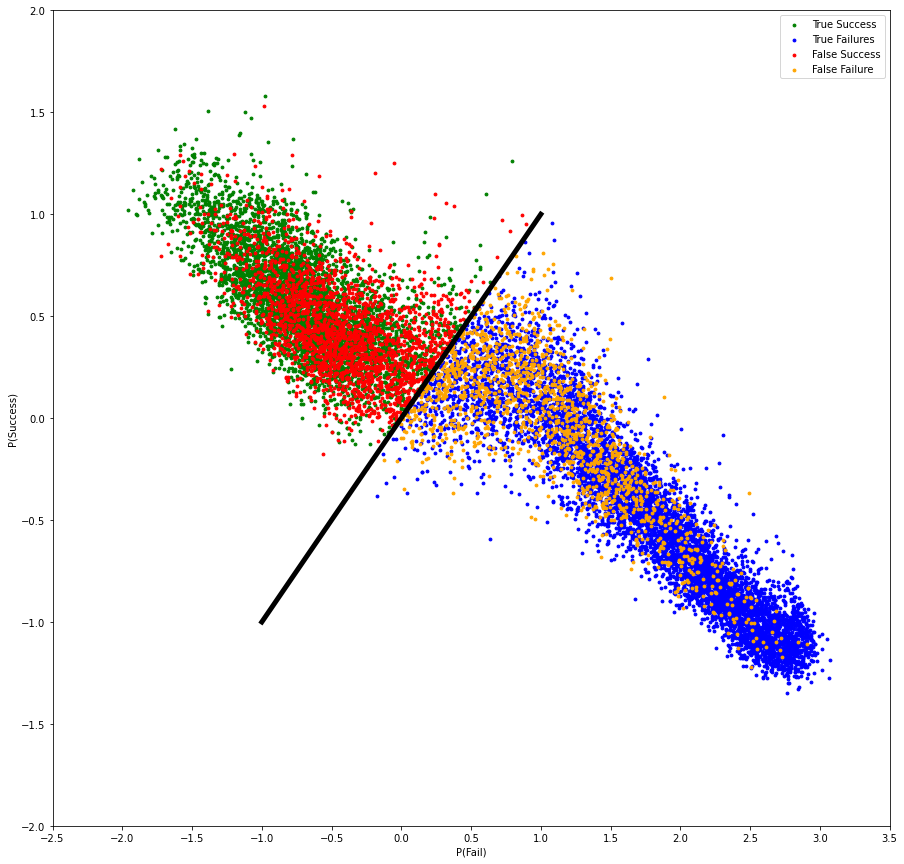

In [62]:
plt.figure(figsize=(15,15))
plt.scatter(np.asarray(tp)[:,0], np.asarray(tp)[:,1], color='g', s=8, label='True Success') # good answers accepted
plt.scatter(np.asarray(tn)[:,0], np.asarray(tn)[:,1], color='b', s=8, label='True Failures') # bad answers rejfected
plt.scatter(np.asarray(fp)[:,0], np.asarray(fp)[:,1], color='r', s=8, label='False Success') # bad answers approved
plt.scatter(np.asarray(fn)[:,0], np.asarray(fn)[:,1], color='orange', s=8, label='False Failure') # good answers rejected
plt.plot(np.linspace(-1,1,num=12), np.linspace(-1,1,num=12), color='black', linewidth=5)
plt.xlabel('P(Fail)')
plt.ylabel('P(Success)')
plt.yticks(np.linspace(-2,2,num=9))
plt.xticks(np.linspace(-2.5, 3.5,num=13))
plt.legend()
plt.savefig(abspath_curr+'plots/scatter_plot_v0.png')
plt.show()

## Scatter plot with Histogram and Distribution Plot

In [65]:
probs_plot = np.vstack(( np.asarray(tp), np.asarray(tn), np.asarray(fp), np.asarray(fn) ))
labels_plot = preds = np.concatenate(([1]*len(tp), [0]*len(tn), [0]*len(fp), [1]*len(fn)), axis=0).reshape(-1,1)
df_np = np.hstack((probs_plot, labels_plot))
df = pd.DataFrame(df_np, columns=['probs_plot_pf', 'probs_plot_ps', 'labels_plot'])
preds_plot = np.concatenate((['True Success']*len(tp), ['True Fail']*len(tn), ['False Success']*len(fp), ['False Fail']*len(fn)), axis=0)
preds_plot = pd.Series(preds_plot)
df =pd.concat([df, preds_plot], axis=1)
df.rename({0:'preds_plot'}, inplace=True, axis=1)
df.to_csv(abspath_curr+'plots/histogram', index=False)

In [66]:
df = pd.read_csv(abspath_curr+'plots/histogram')
df.head()

,probs_plot_pf,probs_plot_ps,labels_plot,preds_plot
0,-1.458597,1.137198,1.0,True Success
1,-0.754833,0.631535,1.0,True Success
2,-0.662907,0.448379,1.0,True Success
3,-0.936225,0.691100,1.0,True Success
4,-0.621271,0.567788,1.0,True Success


In [67]:
df.describe()

,probs_plot_pf,probs_plot_ps,labels_plot
count,15000.000000,15000.000000,15000.000000
mean,0.648915,0.010047,0.397867
std,1.285419,0.613763,0.489474
min,-1.957897,-1.349430,0.000000
25%,-0.548520,-0.496364,0.000000
50%,0.607011,0.152186,0.000000
75%,1.798348,0.478240,1.000000
max,3.069419,1.578795,1.000000


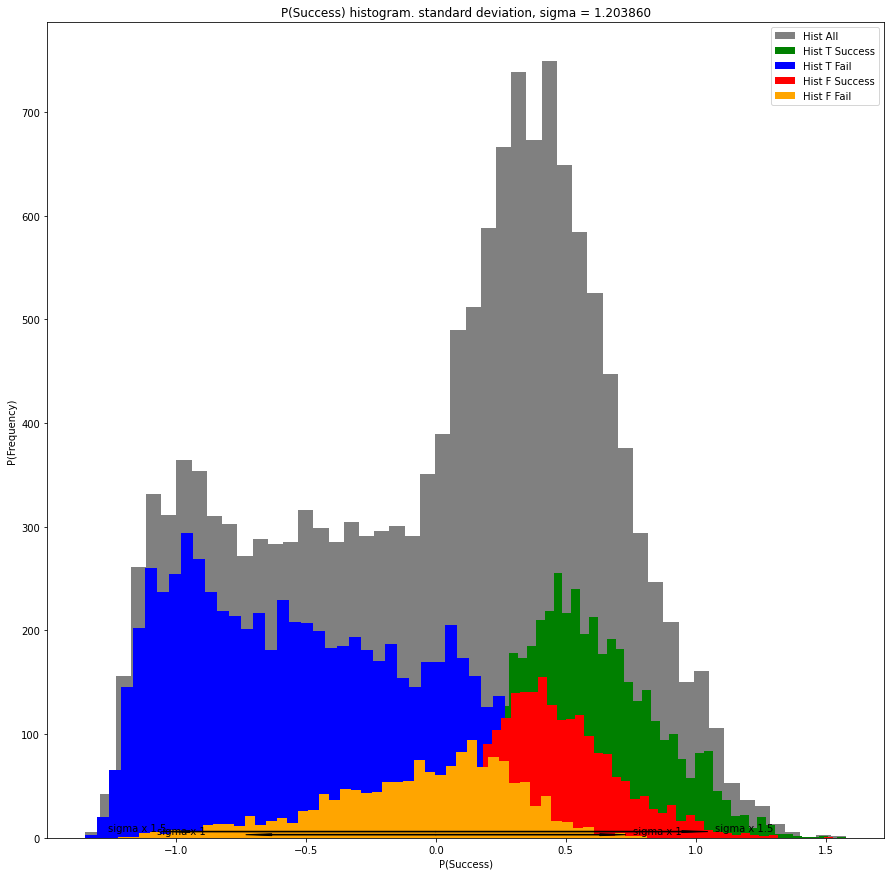

In [68]:
bins = 50
std = 0.631535
plt.figure(figsize=(15,15))
plt.hist(df['probs_plot_ps'], bins=bins, color='grey', density=False,label='Hist All')
plt.hist(df[df['preds_plot']=='True Success']['probs_plot_ps'], bins=bins, color='green', label='Hist T Success')
plt.hist(df[df['preds_plot']=='True Fail']['probs_plot_ps'], bins=bins, color='blue', label='Hist T Fail')
plt.hist(df[df['preds_plot']=='False Success']['probs_plot_ps'], bins=bins, color='red', label='Hist F Success')
plt.hist(df[df['preds_plot']=='False Fail']['probs_plot_ps'], bins=bins, color='orange', label='Hist F Fail')
plt.arrow(x=0, y=3, dx= std, dy=0,width=0.6, head_length=0.1, color='black' )
plt.arrow(x=0, y=3, dx= -std, dy=0,width=0.6, head_length=0.1, color='black' )
plt.arrow(x=0, y=6, dx= std*1.5, dy=0,width=0.6, head_length=0.1, color='black' )
plt.arrow(x=0, y=6, dx= -std*1.5, dy=0,width=0.6, head_length=0.1, color='black' )
# plt.arrow(x=0, y=9, dx= std*3, dy=0,width=0.6, head_length=0.1, color='black' )
# plt.arrow(x=0, y=9, dx= -std*3, dy=0,width=0.6, head_length=0.1, color='black' )
plt.text(x= std*1.2, y=3,s='sigma x 1')
plt.text(x= -std*1.7, y=3,s='sigma x 1')
plt.text(x= std*1.7, y=6,s='sigma x 1.5')
plt.text(x= -std*2, y=6,s='sigma x 1.5')
# plt.text(x= std*3.2, y=9,s='sigma x 3')
# plt.text(x= -std*3.7, y=9,s='sigma x 3')
plt.xlabel('P(Success)')
plt.ylabel('P(Frequency)')
plt.title('P(Success) histogram. standard deviation, sigma = 1.203860')
plt.legend()
plt.savefig(abspath_curr+'plots/histogram_success_v0.png')
plt.show()

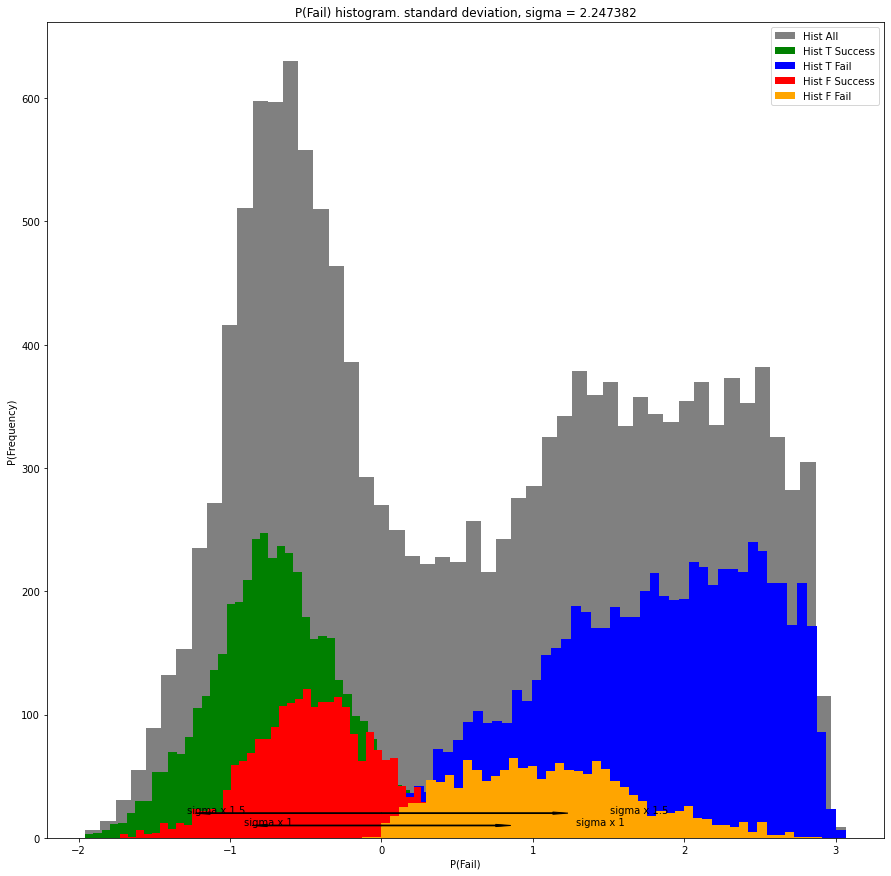

In [71]:
bins = 50
std = -0.754833 	

plt.figure(figsize=(15,15))
plt.hist(df['probs_plot_pf'], bins=bins, color='grey', density=False,label='Hist All')
plt.hist(df[df['preds_plot']=='True Success']['probs_plot_pf'], bins=bins, color='green', label='Hist T Success')
plt.hist(df[df['preds_plot']=='True Fail']['probs_plot_pf'], bins=bins, color='blue', label='Hist T Fail')
plt.hist(df[df['preds_plot']=='False Success']['probs_plot_pf'], bins=bins, color='red', label='Hist F Success')
plt.hist(df[df['preds_plot']=='False Fail']['probs_plot_pf'], bins=bins, color='orange', label='Hist F Fail')
plt.arrow(x=0, y=10, dx= std, dy=0,width=0.6, head_length=0.1, color='black' )
plt.arrow(x=0, y=10, dx= -std, dy=0,width=0.6, head_length=0.1, color='black' )
plt.arrow(x=0, y=20, dx= std*1.5, dy=0,width=0.6, head_length=0.1, color='black' )
plt.arrow(x=0, y=20, dx= -std*1.5, dy=0,width=0.6, head_length=0.1, color='black' )
# plt.arrow(x=0, y=9, dx= std*3, dy=0,width=0.6, head_length=0.1, color='black' )
# plt.arrow(x=0, y=9, dx= -std*3, dy=0,width=0.6, head_length=0.1, color='black' )
plt.text(x= std*1.2, y=10,s='sigma x 1')
plt.text(x= -std*1.7, y=10,s='sigma x 1')
plt.text(x= std*1.7, y=20,s='sigma x 1.5')
plt.text(x= -std*2, y=20,s='sigma x 1.5')
# plt.text(x= std*3.2, y=9,s='sigma x 3')
# plt.text(x= -std*3.7, y=9,s='sigma x 3')
plt.xlabel('P(Fail)')
plt.ylabel('P(Frequency)')
plt.title('P(Fail) histogram. standard deviation, sigma = 2.247382')
plt.legend()
plt.savefig(abspath_curr+'plots/histogram_fail_v0.png')
plt.show()

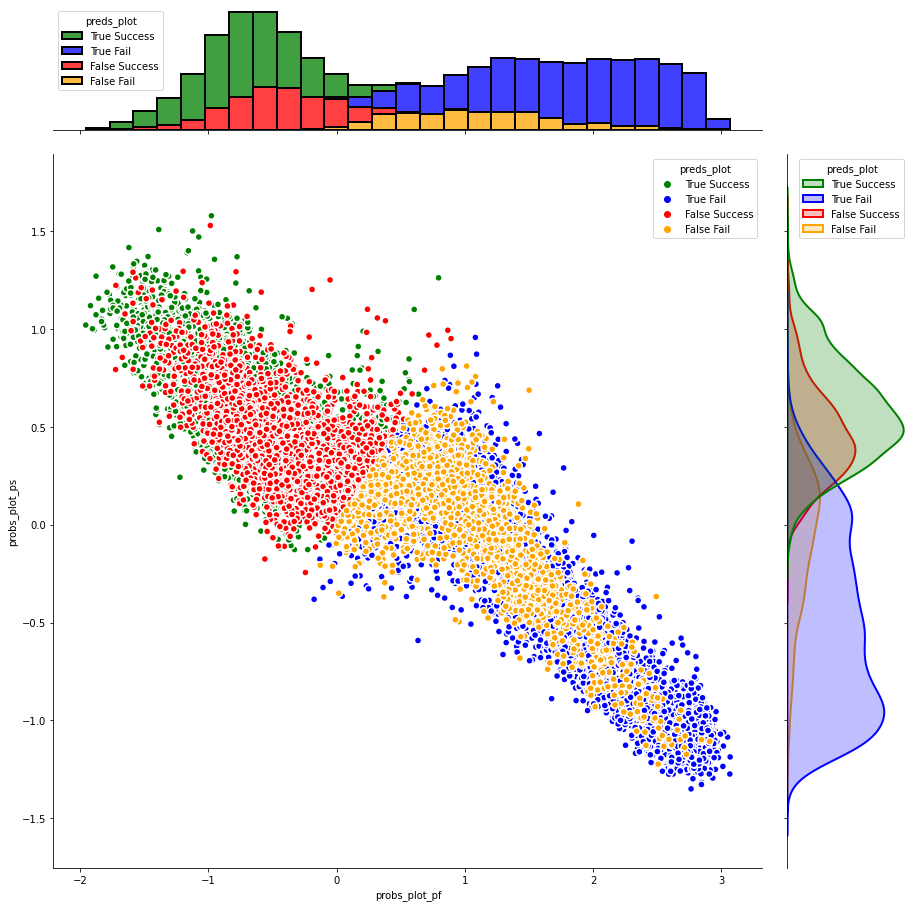

In [72]:
g = sns.JointGrid(height=12.5)
x, y = df["probs_plot_pf"], df["probs_plot_ps"]
sns.scatterplot(x=x, y=y, hue= df['preds_plot'], s=50, linewidth=1.5, ax=g.ax_joint,palette=['g','b','r','orange'])
sns.histplot(x=x, fill=True, linewidth=2, ax=g.ax_marg_x, hue= df['preds_plot'], multiple="stack",palette=['g','b','r','orange'])
sns.kdeplot(y=y, linewidth=2, fill=True, ax=g.ax_marg_y, hue= df['preds_plot'],palette=['g','b','r','orange'])
g.savefig(abspath_curr+'plots/scatter_kde_hist_plot_v0.png')

## Word Frequency Distribution Plots for Questions and Answers of Both GLUE and GW Datasets

In [74]:
# bert_preprocess.
import nltk
nltk.download('stopwords')
import string
from nltk.tokenize import TreebankWordTokenizer
treebank_tokenizer = TreebankWordTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
puncts = [punct for  punct in string.punctuation]+["'", "'s", "``", "`", '"',"''"]+[num for num in '1234567890']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [75]:
gw_sentences_words = [treebank_tokenizer.tokenize(sentence) for sentence in pd.concat([train_df['sentence'], val_df['sentence']], axis=0).values.tolist()]
gw_all_tokens = [word.lower() for sentence in gw_sentences_words for word in sentence]
gw_content = [w for w in gw_all_tokens if (( w not in stop_words) and (w not in puncts))]

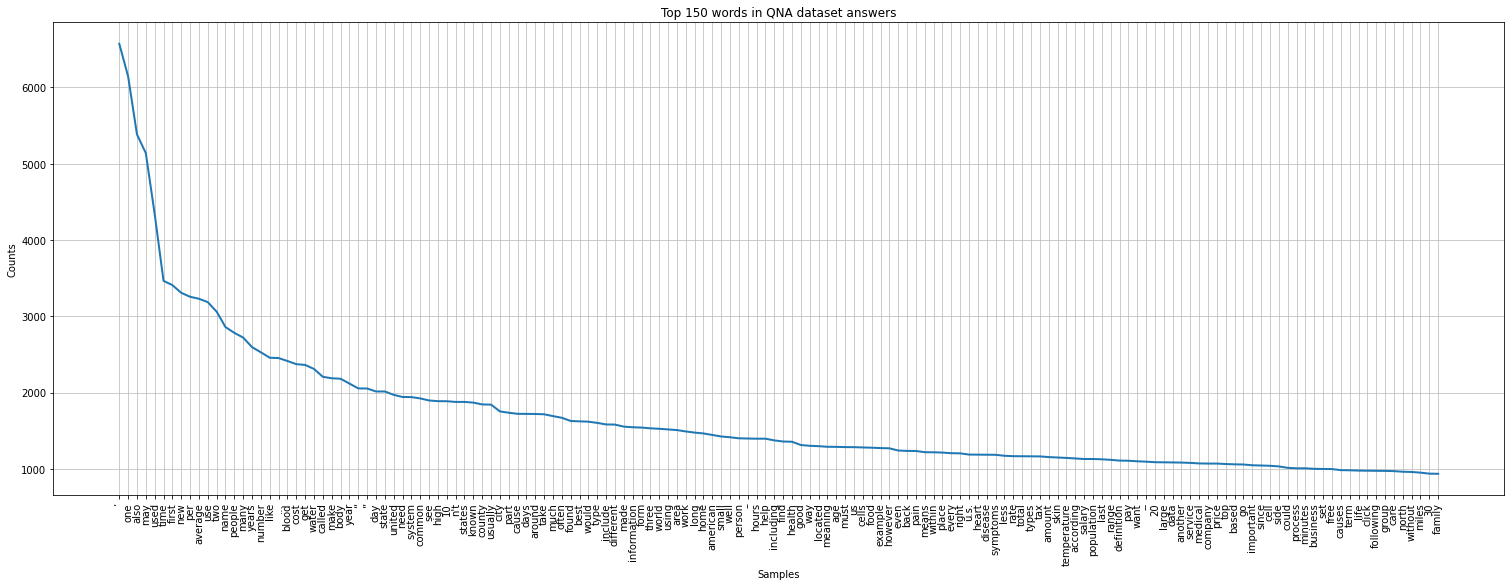

In [76]:
fig = plt.figure(figsize = (26,9))
plt.gcf().subplots_adjust(bottom=0.15)
freq_gw = nltk.FreqDist(gw_content)
freq_gw.plot(150, title='Top 150 words in QNA dataset answers')
fig.savefig(abspath_curr+'plots/freqDist_gw_answers_v0.png', bbox_inches = "tight")
plt.show()

In [77]:
gw_sentences_words_question = [treebank_tokenizer.tokenize(sentence) for sentence in pd.concat([train_df['query'], val_df['query']], axis=0).values.tolist()]
gw_all_tokens_question = [word.lower() for sentence in gw_sentences_words_question for word in sentence]
gw_content_question = [w for w in gw_all_tokens_question if (( w not in stop_words) and (w not in puncts))]

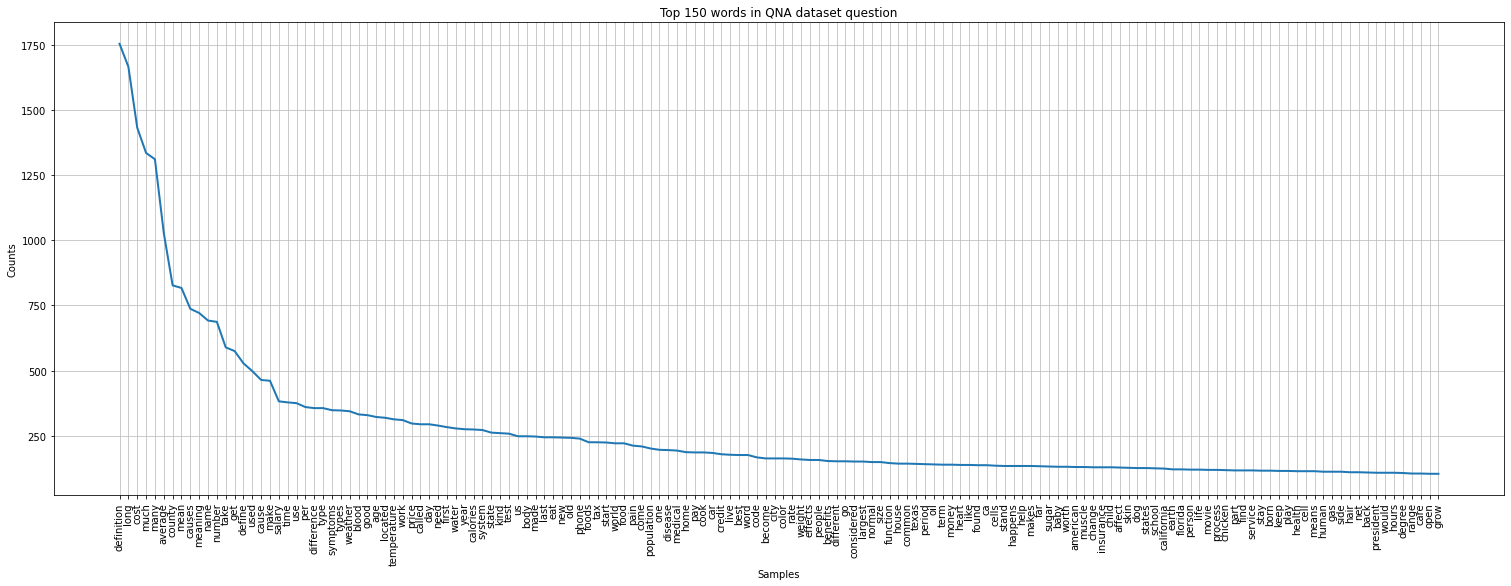

In [78]:
fig = plt.figure(figsize = (26,9))
plt.gcf().subplots_adjust(bottom=0.15)
freq_gw_question = nltk.FreqDist(gw_content_question)
freq_gw_question.plot(150, title='Top 150 words in QNA dataset question')
fig.savefig(abspath_curr+'plots/freqDist_gw_questions_v0.png', bbox_inches = "tight")
plt.show()